Epoch: 0 Rec_error: 27.827611123167685 Reg_error: 2.2950397780582366 Total_error 30.12265090122592
Epoch: 20 Rec_error: 23.747878244338686 Reg_error: 2.9394964924228373 Total_error 26.687374736761523
Epoch: 40 Rec_error: 22.705246307586965 Reg_error: 3.938964745411063 Total_error 26.644211052998028
Epoch: 60 Rec_error: 22.379209010456368 Reg_error: 4.164510221105299 Total_error 26.543719231561667
Epoch: 80 Rec_error: 21.828514934828465 Reg_error: 4.693108341344351 Total_error 26.521623276172818
Epoch: 100 Rec_error: 22.056254367070235 Reg_error: 4.345007004129551 Total_error 26.401261371199787
Epoch: 120 Rec_error: 21.8401410336843 Reg_error: 4.8573472688724575 Total_error 26.697488302556756
Epoch: 140 Rec_error: 21.644368932695954 Reg_error: 4.979773383579951 Total_error 26.624142316275904
Epoch: 160 Rec_error: 21.683933437023178 Reg_error: 4.842358939174969 Total_error 26.526292376198146
Epoch: 180 Rec_error: 21.371236964855804 Reg_error: 5.024712226795128 Total_error 26.395949191650

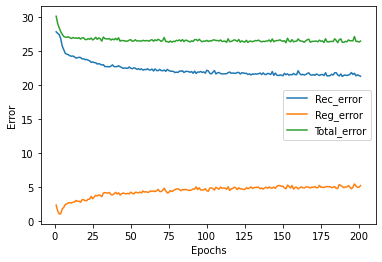

In [4]:
import numpy as np
# import cupy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- 각 설정값 --
img_size = 8
n_in_out = img_size * img_size
n_mid = 16
n_z = 2

eta = 0.001
epochs = 201
batch_size = 32
interval = 20

# -- 훈련 데이터 생성 --
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)   # GPU 대응
x_train /= 15
t_train = digits_data.target

# -- 각 신경망층에서 상속할 입력층 --
class BaseLayer:
    def updata(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 은닉층 --
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # He의 초깃값
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)   # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 정규분포의 파라미터를 계산하는 신경망층 --
class ParamsLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u                # 항등 함수
    
    def backward(self, grad_y):
        delta = grad_y
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 출력층 --
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))    # 시그모이드 함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 잠재 변수를 샘플링하는 층 --
class LatentLayer:
    def forward(self, mu, log_var):
        self.mu = mu               # 평균
        self.log_var = log_var     # 분산의 로그
        
        self.epsilon = np.random.randn(*log_var.shape)
        self.z = mu + self.epsilon*np.exp(log_var/2)
        
    def backward(self, grad_z):
        self.grad_mu = grad_z + self.mu
        self.grad_log_var = grad_z*self.epsilon/2*np.exp(self.log_var/2) - 0.5*(1-np.exp(self.log_var))
        
# -- 각 신경망층의 초기화 --
# 인코더
middle_layer_enc = MiddleLayer(n_in_out, n_mid)
mu_layer = ParamsLayer(n_mid, n_z)
log_var_layer = ParamsLayer(n_mid, n_z)
z_layer = LatentLayer()

# 디코더
middle_layer_dec = MiddleLayer(n_z, n_mid)
output_layer = OutputLayer(n_mid, n_in_out)

# -- 순전파 함수 --
def forward_propagation(x_mb):
    # 인코더
    middle_layer_enc.forward(x_mb)
    mu_layer.forward(middle_layer_enc.y)
    log_var_layer.forward(middle_layer_enc.y)
    z_layer.forward(mu_layer.y, log_var_layer.y)
    
    # 디코더
    middle_layer_dec.forward(z_layer.z)
    output_layer.forward(middle_layer_dec.y)
    
# -- 역전파 함수 --
def backpropagation(t_mb):
    # 디코더
    output_layer.backward(t_mb)
    middle_layer_dec.backward(output_layer.grad_x)
    
    # 인코더
    z_layer.backward(middle_layer_dec.grad_x)
    log_var_layer.backward(z_layer.grad_log_var)
    mu_layer.backward(z_layer.grad_mu)
    middle_layer_enc.backward(mu_layer.grad_x + log_var_layer.grad_x)
    
# -- 파라미터 갱신 함수 --
def updata_params():
    middle_layer_enc.updata(eta)
    mu_layer.updata(eta)
    log_var_layer.updata(eta)
    middle_layer_dec.updata(eta)
    output_layer.updata(eta)
    
# -- 오차 계산 함수 --
def get_rec_error(y, t):
    eps = 1e-7
    return -np.sum(t*np.log(y+eps) + (1-t)*np.log(1-y+eps)) / len(y)

def get_reg_error(mu, log_var):
    return -np.sum(1+log_var - mu**2 - np.exp(log_var)) / len(mu)

rec_error_record = []
reg_error_record = []
total_error_record = []
n_batch = len(x_train) // batch_size

for i in range(epochs):
    # -- 학습 --
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)   # 인덱스 뒤섞기(셔플하기)
    for j in range(n_batch):
        # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        
        # 순전파와 역전파 함수 실행
        forward_propagation(x_mb)
        backpropagation(x_mb)
        
        # 가중치와 편향 업데이트
        updata_params()
    
    # -- 오차 계산 --
    forward_propagation(x_train)
    
    rec_error = get_rec_error(output_layer.y, x_train)
    reg_error = get_reg_error(mu_layer.y, log_var_layer.y)
    total_error = rec_error + reg_error
    
    rec_error_record.append(rec_error)
    reg_error_record.append(reg_error)
    total_error_record.append(total_error)
    
    # -- 결과 확인 --
    if i%interval == 0:
        print("Epoch:", i, "Rec_error:", rec_error, "Reg_error:", reg_error, "Total_error", total_error)
        
plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

    잠재 공간의 시각화

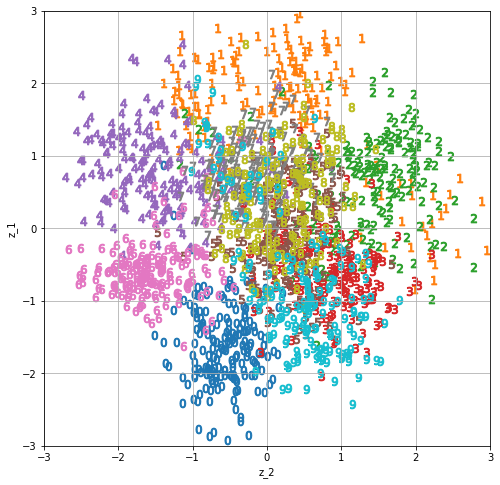

In [6]:
# 잠재 변수 계산
forward_propagation(x_train)

# 잠재 변수를 평면에 펼침
plt.figure(figsize=(8,8))
for i in range(10):
    zt = z_layer.z[t_train==i]
    z_1 = zt[:, 0]           # y축
    z_2 = zt[:, 1]           # x축
    marker = "$"+str(i)+"$"  # 숫자를 나타내는 마커
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)
    
plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()


    이미지 생성

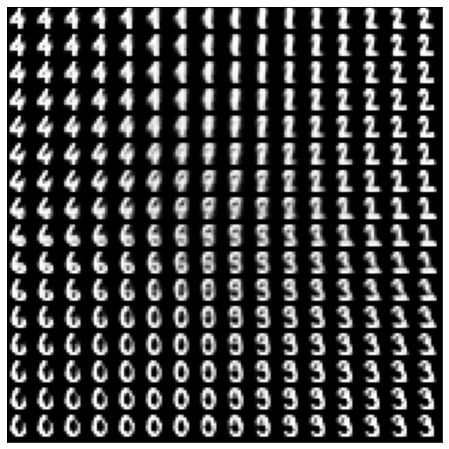

In [7]:
# 이미지 설정
n_img = 16   # 이미지 16x16장을 늘어 놓음
img_size_spaced = img_size + 2

# 이미지 전체
matrix_image = np.zeros((img_size_spaced * n_img, img_size_spaced * n_img))

# 잠재 변수
z_1 = np.linspace(3, -3, n_img)  # 행
z_2 = np.linspace(-3, 3, n_img)  # 열

# 잠재 변수를 변화시켜 이미지 생성
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = np.array([float(z1), float(z2)])
        middle_layer_dec.forward(x)               # 은닉층의 디코더
        output_layer.forward(middle_layer_dec.y)  # 출력층의 디코더
        image = output_layer.y.reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top : top+img_size, left: left+img_size] = image
        
plt.figure(figsize=(8,8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")

# 축 눈금의 레이블과 선을 삭제
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()